# The following code describes how to generate distances for APOGEE DR14 with astroNN

`contspec_dr14.fits` can be generated with instruction described in `Datasets_Data_Reduction.ipynb`

And the following describe how to generate `apogee_dr14_nn_dist.fits`

In [ ]:
from astroNN.models import load_folder
from astroNN.nn.numpy import median_absolute_percentage_error
from astroNN.apogee import allstar
from astroNN.datasets.xmatch import xmatch
from astroNN.gaia import gaiadr2_parallax, extinction_correction, fakemag_to_pc, fakemag_to_parallax
import h5py
import numpy as np
from astropy.io import fits

allstar_file = fits.open(allstar(dr=14))
allstar_data = allstar_file[1].data
ra, dec = allstar_data["RA"], allstar_data["DEC"]
corrected_K = extinction_correction(allstar_file[1].data['K'], allstar_file[1].data['AK_TARG'])

file = fits.open("contspec_dr14.fits")  # see instruction to generate contspec_dr14.fits
all_spec = file[0].data

# cross matched APOGEE-Gaia DR2
apogeegaia_file = fits.getdata("apogeedr14_gaiadr2_xmatch.fits")
# add the offset we found for inv var weighting parallax
parallax = apogeegaia_file["parallax"] + 0.0525
parallax_error = apogeegaia_file["parallax_error"]

# inference
net = load_folder("astroNN_constant_model_reduced")
pred, pred_err = net.test(all_spec)
pred[:, 0][pred[:, 0]==0.] = -9999.

# unit conversion
nn_dist, nn_dist_err = fakemag_to_pc(pred[:, 0], corrected_K, pred_err['total'][:, 0])
_, nn_dist_model_err = fakemag_to_pc(pred[:, 0], corrected_K, pred_err['model'][:, 0])
nn_parallax, nn_parallax_err = fakemag_to_parallax(pred[:, 0], corrected_K, pred_err['total'][:, 0])
_, nn_parallax_model_err = fakemag_to_parallax(pred[:, 0], corrected_K, pred_err['model'][:, 0])

# remove astropy units
nn_dist = nn_dist.value
nn_dist_err = nn_dist_err.value
nn_dist_model_err = nn_dist_model_err.value
nn_parallax = nn_parallax.value
nn_parallax_err = nn_parallax_err.value
nn_parallax_model_err = nn_parallax_model_err.value

# set bad value to -9999.
bad_idx = np.all(all_spec == 0., axis=1) | (pred[:, 0] < 0.)
nn_dist[bad_idx] = -9999.
nn_dist_err[bad_idx] = -9999.
nn_dist_model_err[bad_idx] = -9999.
nn_parallax[bad_idx] = -9999.
nn_parallax_err[bad_idx] = -9999.
nn_parallax_model_err[bad_idx] = -9999.

deno = ((1./nn_parallax_model_err**2)+(1./apogeegaia_file['parallax_error']**2))
weighted_parallax = ((nn_parallax/nn_parallax_model_err**2)+(parallax/apogeegaia_file['parallax_error']**2)) / deno
weighted_parallax_err = 1 / deno

# if one of them is -9999, use the value from the other one
weighted_parallax[parallax == -9999.] = nn_parallax[parallax == -9999.]
weighted_parallax_err[parallax == -9999.] = nn_parallax_model_err[parallax == -9999.] ** 2
weighted_parallax[nn_parallax == -9999.] = parallax[nn_parallax == -9999.]
weighted_parallax_err[nn_parallax == -9999.] = parallax_error[nn_parallax == -9999.]**2

# need to take sqrt
weighted_parallax_err = np.ma.sqrt(np.ma.array(weighted_parallax_err, mask=-9999.))

# prepare astropy fits columns
columns_list = []
columns_list.append(fits.Column(name='APOGEE_ID', array=allstar_data['APOGEE_ID'], format="18A"))
columns_list.append(fits.Column(name='LOCATION_ID', array=allstar_data['LOCATION_ID'], format="J"))
columns_list.append(fits.Column(name='RA', array=allstar_data['RA'], format='D'))
columns_list.append(fits.Column(name='DEC', array=allstar_data['DEC'], format='D'))
columns_list.append(fits.Column(name='pc', array=nn_dist, format='D'))  # NN inverse parallax distance in parsec
columns_list.append(fits.Column(name='pc_error', array=nn_dist_err, format='D'))  # NN inverse parallax distance total uncertainty in parsec
columns_list.append(fits.Column(name='pc_model_error', array=nn_dist_model_err, format='D'))  # NN inverse parallax distance model uncertainty in parsec
columns_list.append(fits.Column(name='nn_parallax', array=nn_parallax, format='D'))  # NN parallax in mas
columns_list.append(fits.Column(name='nn_parallax_error', array=nn_parallax_err, format='D'))  # NN parallax uncertainty in mas
columns_list.append(fits.Column(name='nn_parallax_model_error', array=nn_parallax_model_err, format='D'))  # NN parallax model uncertainty in parsec
columns_list.append(fits.Column(name='fakemag', array=pred[:, 0], format='D'))  # raw nn output
columns_list.append(fits.Column(name='fakemag_error', array=pred_err['total'][:, 0], format='D'))
columns_list.append(fits.Column(name='weighted_parallax', array=weighted_parallax, format='D'))  # inv var weighted NN & Gaia parallax
columns_list.append(fits.Column(name='weighted_parallax_error', array=weighted_parallax_err, format='D'))  # NN parallax uncertainty in mas
columns_list.append(fits.Column(name='RA_J2015.5', array=apogeegaia_file['RA_J2015.5'], format='D'))
columns_list.append(fits.Column(name='DEC_J2015.5', array=apogeegaia_file['DEC_J2015.5'], format='D'))
columns_list.append(fits.Column(name='pmra', array=apogeegaia_file['pmra'], format='D'))
columns_list.append(fits.Column(name='pmra_error', array=apogeegaia_file['pmra_error'], format='D'))
columns_list.append(fits.Column(name='pmdec', array=apogeegaia_file['pmdec'], format='D'))
columns_list.append(fits.Column(name='pmdec_error', array=apogeegaia_file['pmdec_error'], format='D'))
columns_list.append(fits.Column(name='phot_g_mean_mag', array=apogeegaia_file['phot_g_mean_mag'], format='D'))
columns_list.append(fits.Column(name='bp_rp', array=apogeegaia_file['bp_rp'], format='D'))

t = fits.BinTableHDU.from_columns(columns_list)
t.writeto('apogee_dr14_nn_dist.fits')

## Below describe informations or claims in paper abstract

Number of stars with <10% uncertainty:  155226
10% and 90% percentile of R from Sun:  6.048344439400587 11.530503287487562


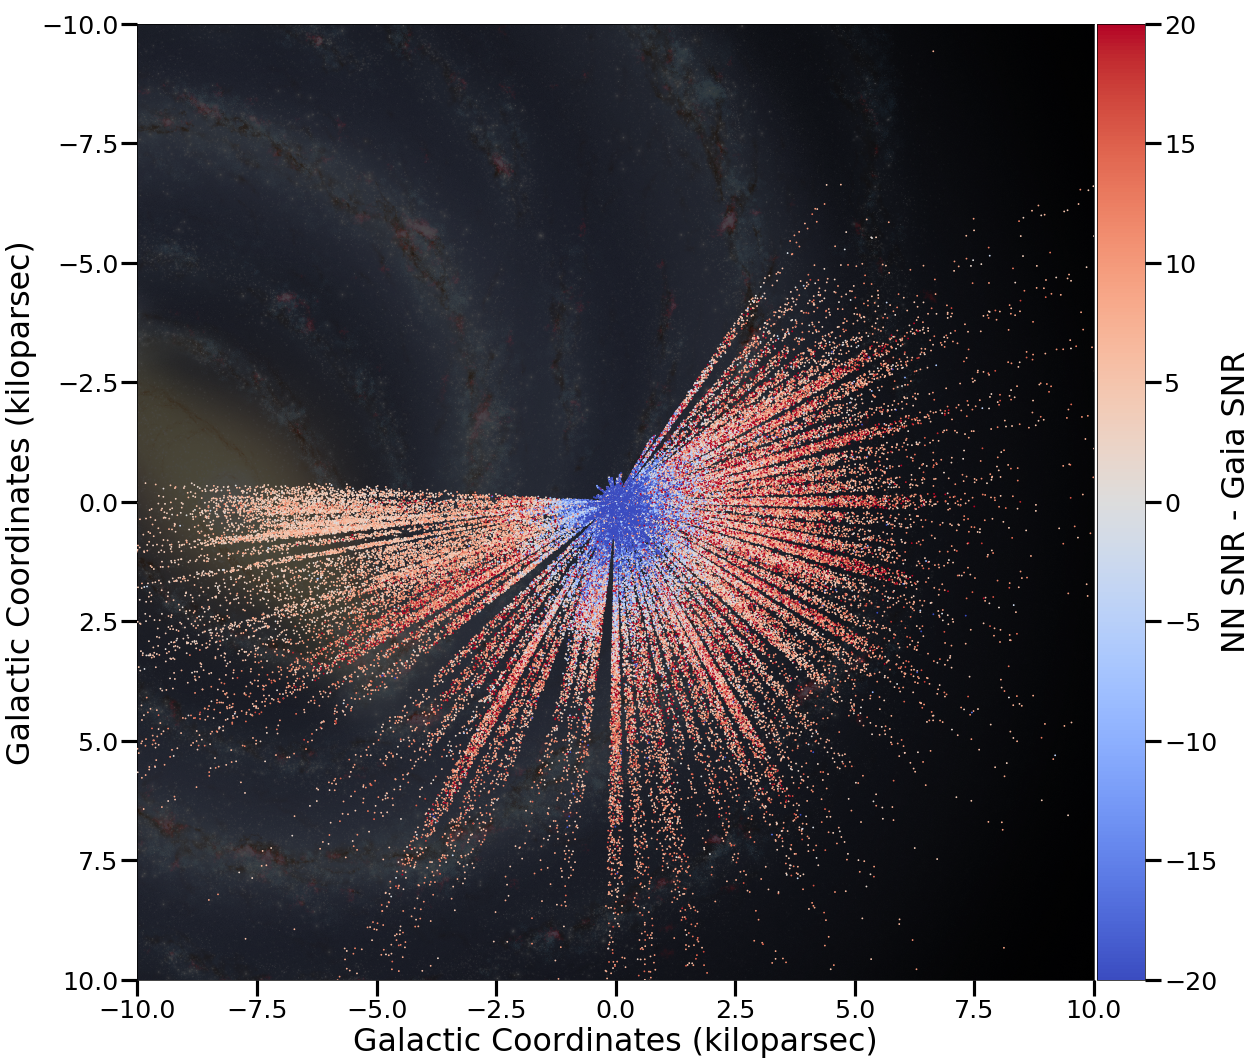

In [2]:
%matplotlib inline
from mw_plot import MWPlot
from galpy.orbit import Orbit
from astropy.io import fits
from astropy import units as  u
import astropy.coordinates as coords
from astropy.coordinates import CartesianDifferential
import numpy as np
import pylab as plt

apogeegaia_file = fits.getdata("apogeedr14_gaiadr2_xmatch.fits")
# add the offset we found for inv var weighting parallax
parallax = apogeegaia_file["parallax"] + 0.0525
parallax_error = apogeegaia_file["parallax_error"]

f = fits.getdata("apogee_dr14_nn_dist.fits")
nn_distance = f['pc']
nn_distance_error = f['pc_model_error']
ra_j2015_5 = f['RA_J2015.5']  # RA J2015.5
dec_j2015_5 = f['DEC_J2015.5']  # DEC J2015.5

print("Number of stars with <10% uncertainty: ", np.sum(nn_distance / nn_distance_error > 10))

non_n9999_idx = ((nn_distance != -9999.) &
                 (parallax != -9999) &
                 (ra_j2015_5 != -9999.) &
                 (dec_j2015_5 != -9999.))

uncertainty_difference = np.clip((nn_distance / nn_distance_error) - np.abs(parallax / parallax_error), -20, 20)

c = coords.SkyCoord(ra=ra_j2015_5[non_n9999_idx]*u.degree,
                    dec=dec_j2015_5[non_n9999_idx]*u.degree,
                    distance=nn_distance[non_n9999_idx]*u.pc,
                    pm_ra_cosdec=np.ones_like(nn_distance)[non_n9999_idx]*u.mas/u.yr,
                    pm_dec=np.ones_like(nn_distance)[non_n9999_idx]*u.mas/u.yr,
                    radial_velocity=np.ones_like(nn_distance)[non_n9999_idx]*u.km/u.s,
                    galcen_distance=8.125*u.kpc, # https://arxiv.org/abs/1807.09409 (GRAVITY Collaboration 2018)
                    z_sun=20.8*u.pc, # https://arxiv.org/abs/1809.03507 (Bennett & Bovy 2018)
                    galcen_v_sun=CartesianDifferential([11.1, 245.7, 7.25]*u.km/u.s))

good_idx = ((np.abs(c.galactic.cartesian.z.value) < 500))

print("10% and 90% percentile of R(kpc) from Sun: ", np.percentile(Orbit(c).R(), 10), np.percentile(Orbit(c).R(), 90))

c2 = c[good_idx]

# setup a MWPlot instance
plot_instance = MWPlot(radius=10 * u.kpc, unit=u.kpc, coord='galactic', annotation=False)

# so that the colorbar will has a better contract
# plot_instance.clim = (-0.4, 0.4)
plot_instance.dpi=65
plot_instance.cmap = 'coolwarm'

# alpha value for the nmilkyway image
plot_instance.imalpha = 0.3

# set up plot title
# plot_instance.title = 'APOGEE DR14 Distance with 20% uncertainty cuts \n within 0.5kpc from galactic midplane \n NN $[Fe/H]$ with 0.05 dex uncertainty cuts'

# use mw_scatter instead of scatter because we want a colorbar
# need to flip the sign of x because astropy is left-handed but mw_plot is right-handed
plot_instance.mw_scatter(-c2.galactic.cartesian.x, c2.galactic.cartesian.y,
                         [uncertainty_difference[non_n9999_idx][good_idx], 'NN SNR - Gaia SNR'])

# Comparison to other spectro-photometric distances

APOGEE BPG: https://www.sdss.org/dr14/data_access/value-added-catalogs/?vac_id=apogee-dr14-based-distance-estimations
<br>APOGEE RC: https://www.sdss.org/dr14/data_access/value-added-catalogs/?vac_id=apogee-red-clump-rc-catalog
<br>Hogg et al.: https://github.com/aceilers/spectroscopic_parallax

E:\sdss_mirror\dr14/apogee/vac/apogee-distances/apogee_distances-DR14.fits was found!
E:\sdss_mirror\dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/allStar-l31c.2.fits was found!
E:\sdss_mirror\dr14/apogee/vac/apogee-rc/cat/apogee-rc-DR14.fits was found!


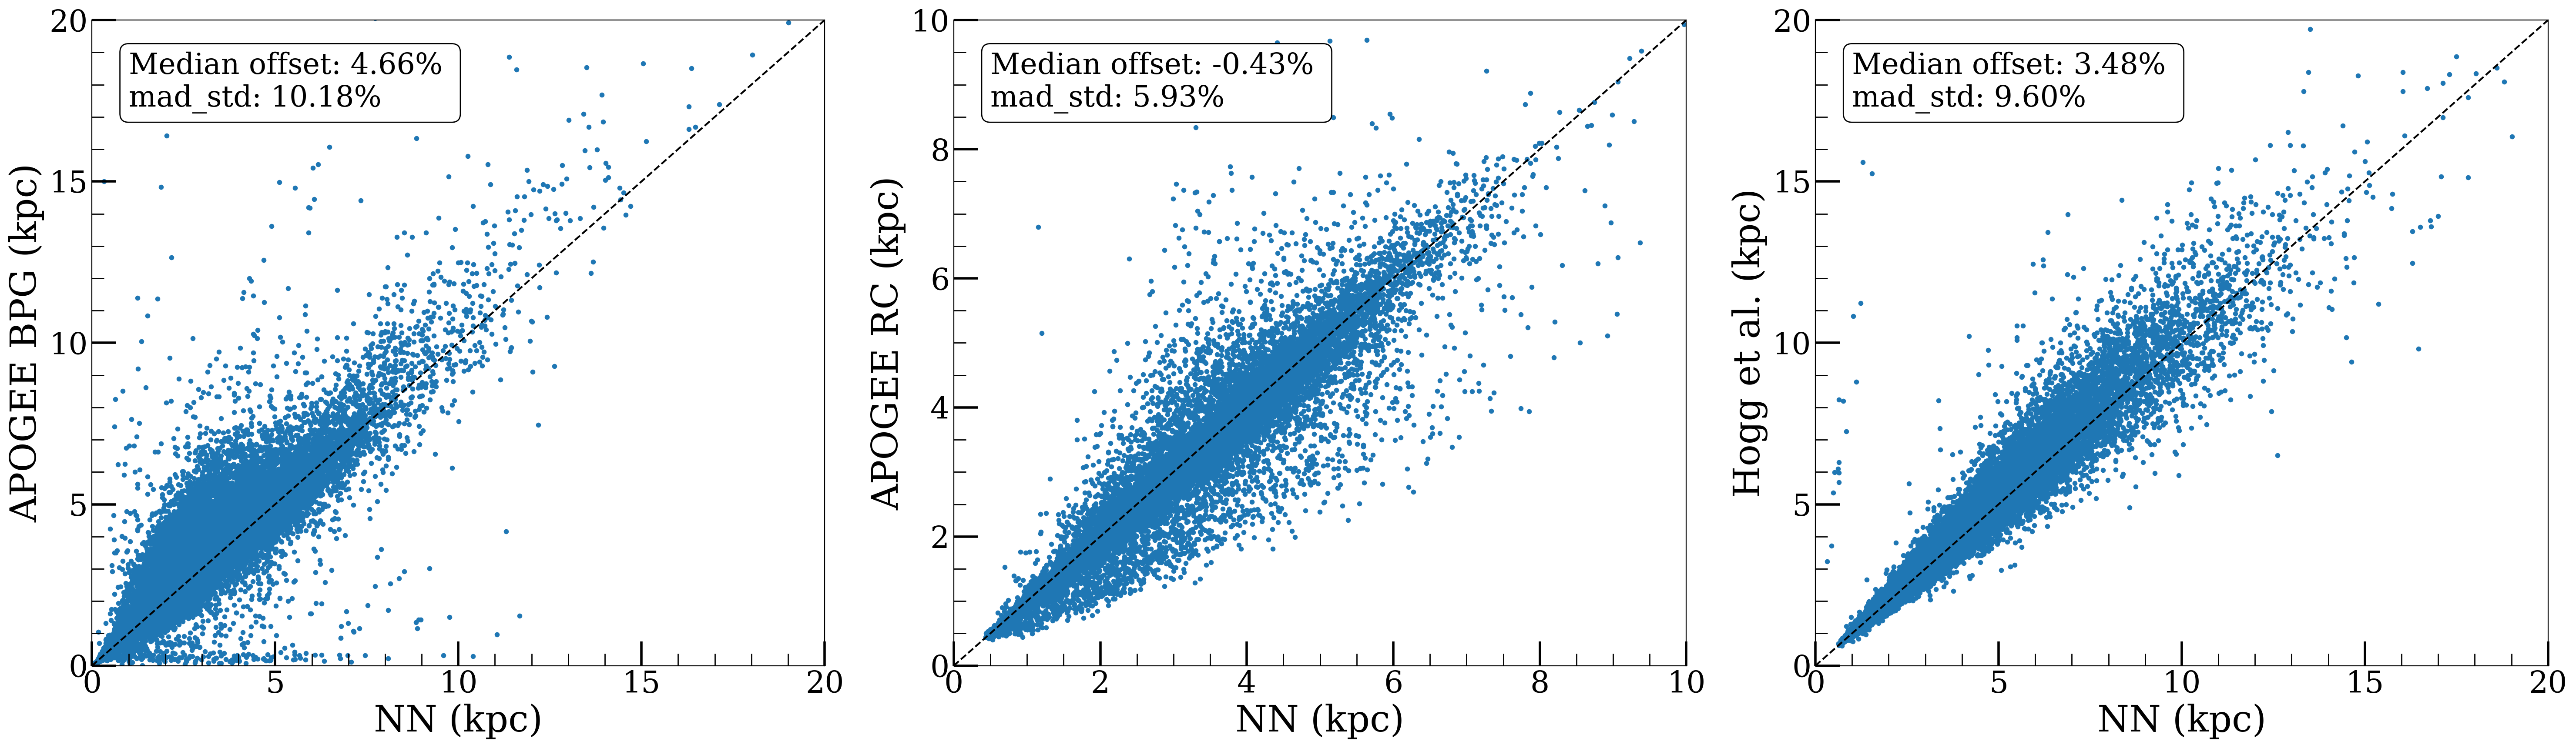

In [1]:
%matplotlib inline
import numpy as np
import pylab as plt

from astropy.io import fits
from astropy.stats import mad_std

from astroNN.nn.numpy import median_absolute_percentage_error
from astroNN.apogee import allstar
from astroNN.datasets import xmatch
from astroNN.datasets import load_apogee_distances, load_apogee_rc

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

astroNN_data = fits.getdata("apogee_dr14_nn_dist.fits")
apogee_id = astroNN_data['APOGEE_ID']
ra = astroNN_data['RA']
dec = astroNN_data['DEC']
astroNN_pc = astroNN_data['pc']
astroNN_pc_error = astroNN_data['pc_error']
good_idx = ((astroNN_pc_error!=-9999.) & (astroNN_pc / astroNN_pc_error > 5))

astroNN_teff = fits.getdata("astroNN_apogee_dr14_catalog.fits")['astroNN'][:, 0][good_idx]
astroNN_logg = fits.getdata("astroNN_apogee_dr14_catalog.fits")['astroNN'][:, 1][good_idx]

# BPG
additional_idx = ((astroNN_teff < 5250) & (astroNN_logg < 3.5))
bpg_RA, bpg_DEC, bpg_pc, bpg_pc_err = load_apogee_distances(dr=14, metric='distance', cuts=True, keepdims=False)
idx3, idx4, sep = xmatch(ra[good_idx][additional_idx], bpg_RA, colRA1=ra[good_idx][additional_idx], 
                         colDec1=dec[good_idx][additional_idx], colRA2=bpg_RA, colDec2=bpg_DEC, swap=False)

# red clumps
rc_RA, rc_DEC, rc_pc = load_apogee_rc(dr=14, metric='distance')
non_rc_ra = np.genfromtxt("apogee_non_rc_ra.txt")  # RC contemination from NN logg comparison
ele, idx1, idx2 = np.intersect1d(non_rc_ra, rc_RA, return_indices=True)  # cross-match
rc_RA = np.delete(rc_RA, idx2)
rc_DEC = np.delete(rc_DEC, idx2)
rc_pc = np.delete(rc_pc, idx2)
idx5, idx6, sep = xmatch(ra[good_idx], rc_RA, colRA1=ra[good_idx], colDec1=dec[good_idx], colRA2=rc_RA, colDec2=rc_DEC, swap=False)

# Hogg et al
hogg_data = fits.getdata("data_HoggEilersRix2018.fits")
hogg_id = hogg_data['2mass_id']
hogg_gaia = hogg_data['Gaia_parallax']
hogg_gaia_err = hogg_data['Gaia_parallax_err']
hogg_plx = hogg_data['spec_parallax']
hogg_plx_err = hogg_data['spec_parallax_err']
hogg_pc = 1000 / hogg_plx
hogg_pc_err = hogg_pc * np.array(hogg_data['spec_parallax_err']/hogg_data['spec_parallax'])
hogg_plx[np.isnan(hogg_plx)] = -9999.
hogg_plx_err[np.isnan(hogg_plx)] = -9999.
hogg_good_idx = (hogg_plx / hogg_plx_err > 5)
ele, idx1, idx2 = np.intersect1d(apogee_id[good_idx], hogg_id[hogg_good_idx], return_indices=True)  # cross-match

fig, ax = plt.subplots(1, 3, figsize=(30, 9), dpi=200)
props = dict(boxstyle='round', facecolor='white')

median_per_offset = np.median((bpg_pc[idx4] - astroNN_pc[good_idx][additional_idx][idx3]) / astroNN_pc[good_idx][additional_idx][idx3]) * 100
mad_per_offset = mad_std((astroNN_pc[good_idx][additional_idx][idx3] - bpg_pc[idx4]) / astroNN_pc[good_idx][additional_idx][idx3]) * 100

ax[0].scatter(astroNN_pc[good_idx][additional_idx][idx3] / 1000, bpg_pc[idx4] / 1000, s=10.,rasterized=True)
ax[0].plot([0, 20], [0, 20], 'k--')
ax[0].set_ylabel('APOGEE BPG (kpc)', fontsize=30)
ax[0].set_xlabel('NN (kpc)', fontsize=30)
ax[0].set_xlim(0, 20)
ax[0].set_ylim(0, 20)
ax[0].minorticks_on()
ax[0].set_xticks([0, 5, 10, 15, 20])
ax[0].set_yticks([0, 5, 10, 15, 20])
ax[0].tick_params(labelsize=25, width=2, length=20, which='major')
ax[0].tick_params(width=1, length=10, which='minor')
ax[0].xaxis.set_tick_params(direction='in', which='both')
ax[0].yaxis.set_tick_params(direction='in', which='both')
ax[0].text(0.05, 0.95, f"Median offset: {median_per_offset:.2f}% \nmad_std: {mad_per_offset:.2f}%", fontsize=24, 
           verticalalignment='top', transform=ax[0].transAxes, bbox=props)

median_per_offset = np.median((rc_pc[idx6] - astroNN_pc[good_idx][idx5]) / astroNN_pc[good_idx][idx5]) * 100
mad_per_offset = mad_std((astroNN_pc[good_idx][idx5] - rc_pc[idx6]) / astroNN_pc[good_idx][idx5]) * 100
ax[1].scatter(astroNN_pc[good_idx][idx5] / 1000, rc_pc[idx6] / 1000, s=10., rasterized=True)
ax[1].plot([0, 15], [0, 15], 'k--')
ax[1].set_ylabel('APOGEE RC (kpc)', fontsize=30)
ax[1].set_xlabel('NN (kpc)', fontsize=30)
ax[1].set_xlim(0, 10)
ax[1].set_ylim(0, 10)
ax[1].minorticks_on()
ax[1].tick_params(labelsize=25, width=2, length=20, which='major')
ax[1].tick_params(width=1, length=10, which='minor')
ax[1].xaxis.set_tick_params(direction='in', which='both')
ax[1].yaxis.set_tick_params(direction='in', which='both')
ax[1].text(0.05, 0.95, f"Median offset: {median_per_offset:.2f}% \nmad_std: {mad_per_offset:.2f}%", fontsize=24, 
           verticalalignment='top', transform=ax[1].transAxes, bbox=props)

median_per_offset = np.median((hogg_pc[hogg_good_idx][idx2] - astroNN_pc[good_idx][idx1]) / astroNN_pc[good_idx][idx1]) * 100
mad_per_offset = mad_std((astroNN_pc[good_idx][idx1] - hogg_pc[hogg_good_idx][idx2]) / astroNN_pc[good_idx][idx1]) * 100
ax[2].scatter(astroNN_pc[good_idx][idx1] / 1000, hogg_pc[hogg_good_idx][idx2] / 1000, s=10., rasterized=True)
ax[2].plot([0, 40], [0, 40], 'k--')
ax[2].set_ylabel('Hogg et al. (kpc)', fontsize=30)
ax[2].set_xlabel('NN (kpc)', fontsize=30)
ax[2].set_xlim(0, 20)
ax[2].set_ylim(0, 20)
ax[2].minorticks_on()
ax[2].set_xticks([0, 5, 10, 15, 20])
ax[2].set_yticks([0, 5, 10, 15, 20])
ax[2].tick_params(labelsize=25, width=2, length=20, which='major')
ax[2].tick_params(width=1, length=10, which='minor')
ax[2].xaxis.set_tick_params(direction='in', which='both')
ax[2].yaxis.set_tick_params(direction='in', which='both')
ax[2].text(0.05, 0.95, f"Median offset: {median_per_offset:.2f}% \nmad_std: {mad_per_offset:.2f}%", fontsize=24, 
           verticalalignment='top', transform=ax[2].transAxes, bbox=props)

plt.tight_layout()
plt.savefig("spectrophoto_comparison.pdf")

# Comparison to Gaia in Test set

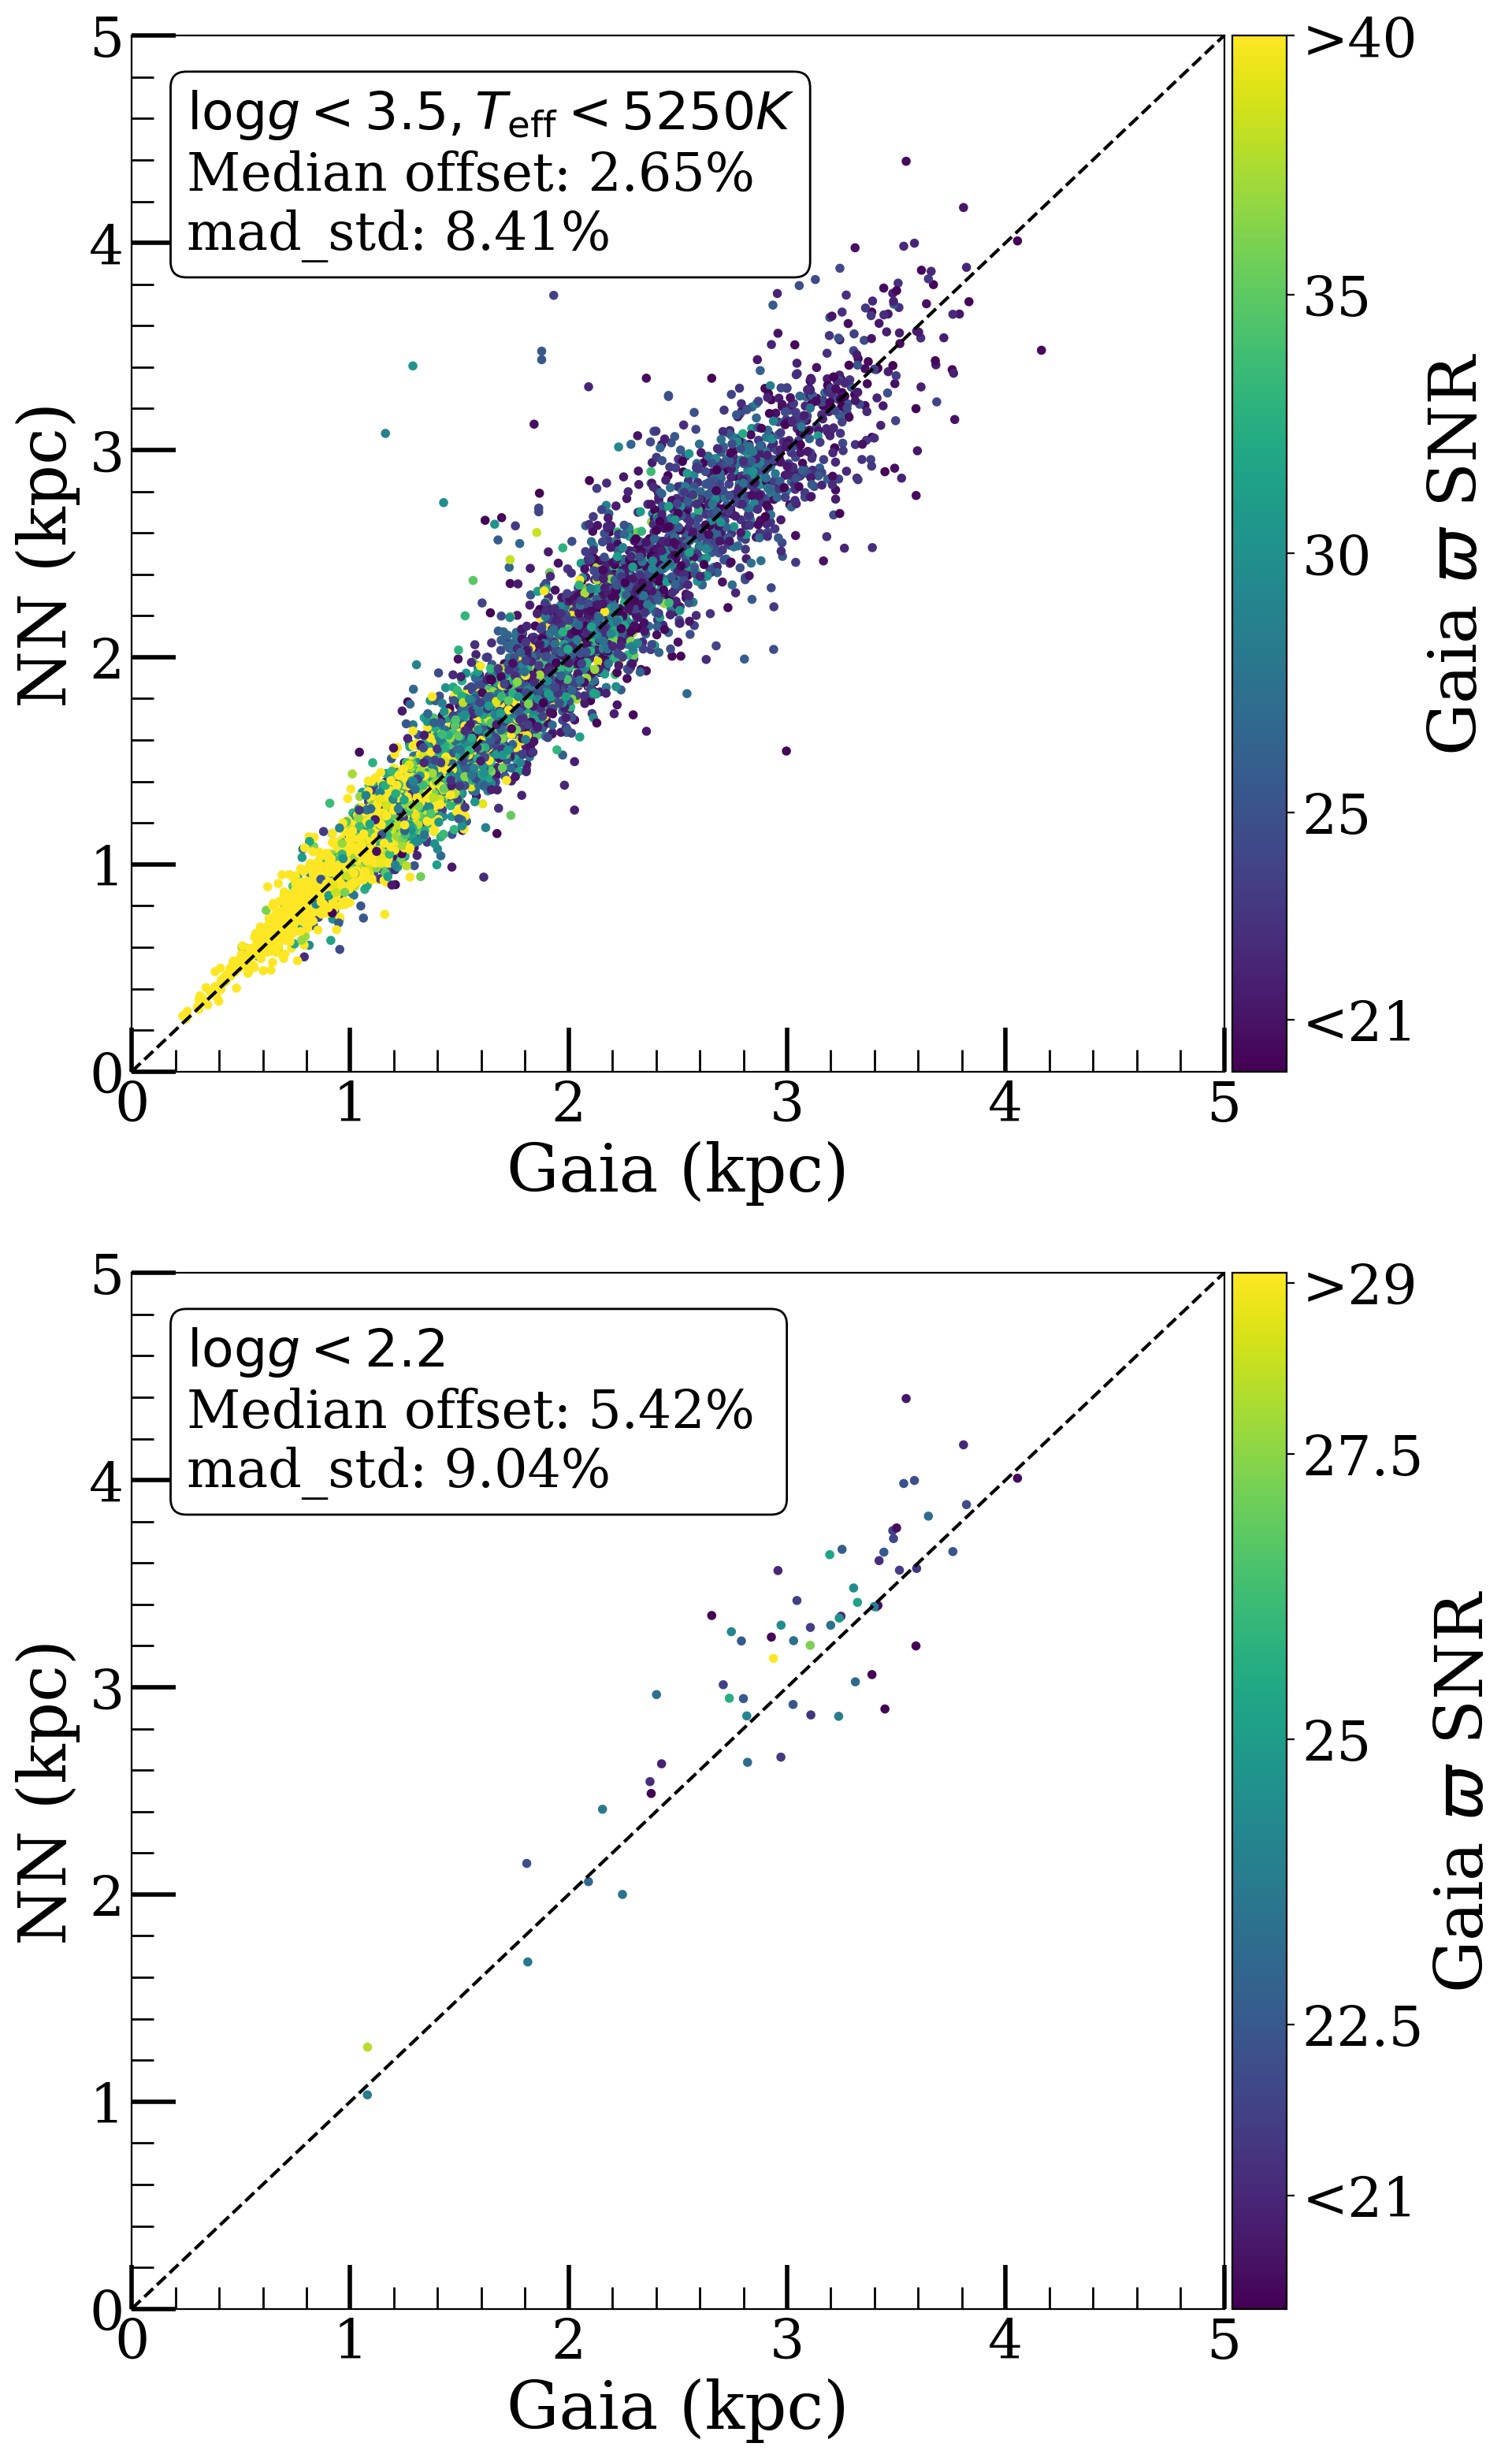

In [1]:
%matplotlib inline
import h5py
import numpy as np
import pylab as plt

from astropy.io import fits
from astropy.stats import mad_std

from astroNN.apogee import allstar
from astroNN.gaia import mag_to_fakemag, fakemag_to_pc, fakemag_to_logsol, fakemag_to_parallax
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter,MultipleLocator, FormatStrFormatter

plt.rc('font', **{'family': 'serif', 'weight': 'medium', 'size': 20})

astroNN_data = fits.getdata("apogee_dr14_nn_dist.fits")
astroNN_pc = astroNN_data['pc']
astroNN_pc_error = astroNN_data['pc_error']

astroNN_teff = fits.getdata("astroNN_apogee_dr14_catalog.fits")['astroNN'][:, 0]
astroNN_logg = fits.getdata("astroNN_apogee_dr14_catalog.fits")['astroNN'][:, 1]

with h5py.File('gaia_dr2_test.h5', 'r') as F:
    allstar_idx = np.array(F['allstar_idx'])  # indices in allstar
    spectra = np.array(F['spectra'])
    parallax = np.array(F['parallax']) + 0.0525
    parallax_err = np.array(F['parallax_err'])
    indx = (parallax / parallax_err > 20)  # do 5% certain gaia parallax
    allstar_idx = allstar_idx[indx]
    
gaia_pc = 1000 / parallax

# do 20% certain NN distance
astronn_pc_plot_idx = ((astroNN_pc[allstar_idx] / astroNN_pc_error[allstar_idx] > 5.) & 
                       (astroNN_logg[allstar_idx] <3.5) & (astroNN_teff[allstar_idx] <5250))

astronn_pc_plot_idx2 = ((astroNN_pc[allstar_idx] / astroNN_pc_error[allstar_idx] > 5.) & 
                        (astroNN_logg[allstar_idx] <2.2))

fig, ax = plt.subplots(2, figsize=(10, 16), dpi=200)
props = dict(boxstyle='round', facecolor='white')

median_per_offset = np.median((astroNN_pc[allstar_idx][astronn_pc_plot_idx] - gaia_pc[indx][astronn_pc_plot_idx]) / gaia_pc[indx][astronn_pc_plot_idx]) * 100
mad_per_offset = mad_std((gaia_pc[indx][astronn_pc_plot_idx] - astroNN_pc[allstar_idx][astronn_pc_plot_idx]) / gaia_pc[indx][astronn_pc_plot_idx]) * 100
mappable = ax[0].scatter(gaia_pc[indx][astronn_pc_plot_idx] / 1000, astroNN_pc[allstar_idx][astronn_pc_plot_idx] / 1000,
                         c=np.clip(parallax[indx][astronn_pc_plot_idx] / parallax_err[indx][astronn_pc_plot_idx], 20, 40), 
                         s=10., rasterized=True)
ax[0].plot([0, 5], [0, 5], 'k--')
ax[0].set_ylabel('NN (kpc)', fontsize=30)
ax[0].set_xlabel('Gaia (kpc)', fontsize=30)
ax[0].set_xlim(0, 5)
ax[0].set_ylim(0, 5)
ax[0].minorticks_on()
ax[0].tick_params(labelsize=25, width=2, length=20, which='major')
ax[0].tick_params(width=1, length=10, which='minor')
ax[0].xaxis.set_tick_params(direction='in', which='both')
ax[0].yaxis.set_tick_params(direction='in', which='both')
# colorbar 
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax, mappable=mappable, ticks=[21, 25, 30, 35, 40])
cbar.ax.tick_params(labelsize=25)
cbar.ax.set_yticklabels(["<21", "25", "30", "35", ">40"])
cbar.set_label(r"Gaia $\varpi$ SNR", size=30)
ax[0].text(0.05, 0.95, r"$\log{g}<3.5, T_\mathrm{eff}<5250K$" + f"\nMedian offset: {median_per_offset:.2f}% \nmad_std: {mad_per_offset:.2f}%", fontsize=24, 
           verticalalignment='top', transform=ax[0].transAxes, bbox=props)

median_per_offset = np.median((astroNN_pc[allstar_idx][astronn_pc_plot_idx2] - gaia_pc[indx][astronn_pc_plot_idx2]) / gaia_pc[indx][astronn_pc_plot_idx2]) * 100
mad_per_offset = mad_std((gaia_pc[indx][astronn_pc_plot_idx2] - astroNN_pc[allstar_idx][astronn_pc_plot_idx2]) / gaia_pc[indx][astronn_pc_plot_idx2]) * 100
mappable = ax[1].scatter(gaia_pc[indx][astronn_pc_plot_idx2] / 1000, astroNN_pc[allstar_idx][astronn_pc_plot_idx2] / 1000,
                         c=np.clip(parallax[indx][astronn_pc_plot_idx2] / parallax_err[indx][astronn_pc_plot_idx2], 20, 40), 
                         s=10., rasterized=True)
ax[1].plot([0, 5], [0, 5], 'k--')
ax[1].set_ylabel('NN (kpc)', fontsize=30)
ax[1].set_xlabel('Gaia (kpc)', fontsize=30)
ax[1].set_xlim(0, 5)
ax[1].set_ylim(0, 5)
ax[1].minorticks_on()
ax[1].tick_params(labelsize=25, width=2, length=20, which='major')
ax[1].tick_params(width=1, length=10, which='minor')
ax[1].xaxis.set_tick_params(direction='in', which='both')
ax[1].yaxis.set_tick_params(direction='in', which='both')
# colorbar 
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax, mappable=mappable, ticks=[21, 22.5, 25, 27.5, 29])
cbar.ax.tick_params(labelsize=25)
cbar.ax.set_yticklabels(["<21", "22.5", "25", "27.5", ">29"])
cbar.set_label(r"Gaia $\varpi$ SNR", size=30)
ax[1].text(0.05, 0.95, r"$\log{g}<2.2$" + f"\nMedian offset: {median_per_offset:.2f}% \nmad_std: {mad_per_offset:.2f}%", fontsize=24, 
           verticalalignment='top', transform=ax[1].transAxes, bbox=props)

fig.tight_layout()
plt.savefig("gaia_5percent.pdf")